In [1]:
import tensorflow as tf

# Set the path to your dataset
data_dir = '/kaggle/input/eye-diseases-classification/dataset'

# Load the dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),  # Resize images to 128x128 (adjust as needed)
    batch_size=32,           # Set batch size
    validation_split=0.2,    # Use 20% of data for validation
    subset='training',       # Load training data
    seed=123                 # Seed for reproducibility
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation',     # Load validation data
    seed=123
)

# Optionally, if you want to create a test dataset from another folder, you can do the same:
# Note: Make sure you have a separate folder for test data, if applicable
# test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     '/path/to/test_dataset',
#     image_size=(128, 128),
#     batch_size=32
# )


Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [2]:
import numpy as np

# Function to convert dataset to numpy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []

    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())

    # Concatenate all batches into single arrays
    images = np.concatenate(images)
    labels = np.concatenate(labels)

    return images, labels

# Convert training and validation datasets to numpy arrays
train_images, train_labels = dataset_to_numpy(train_dataset)
test_images, test_labels = dataset_to_numpy(validation_dataset)

# Optionally, if you have a separate test dataset
# test_images, test_labels = dataset_to_numpy(test_dataset)

# Check the shapes
print(f'Train Images Shape: {train_images.shape}, Train Labels Shape: {train_labels.shape}')
print(f'Test Images Shape: {test_images.shape}, Test Labels Shape: {test_labels.shape}')


Train Images Shape: (3374, 256, 256, 3), Train Labels Shape: (3374,)
Test Images Shape: (843, 256, 256, 3), Test Labels Shape: (843,)


In [3]:
from tensorflow.keras.utils import to_categorical

# Assuming you already have train_labels and test_labels as numpy arrays

# One-hot encode the labels
num_classes = 4  # Adjust this based on your number of classes
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# Check the shapes of the one-hot encoded labels
print(f'Train Labels One-Hot Shape: {train_labels.shape}')
print(f'Test Labels One-Hot Shape: {test_labels.shape}')


Train Labels One-Hot Shape: (3374, 4)
Test Labels One-Hot Shape: (843, 4)


In [4]:
train_images = train_images.reshape((3374, 256, 256, 3)).astype('float32') / 255 
test_images = test_images.reshape((843, 256, 256, 3)).astype('float32') / 255 

In [5]:
train_labels

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Multiply, Reshape, GlobalAveragePooling2D, Input
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [25]:
def cnn_with_attention_initial():
    input_layer = Input(shape=(256, 256, 3))

    # CNN Layers
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Attention mechanism
    intermediate_features = x
    attention_weights = GlobalAveragePooling2D()(intermediate_features)  # Create a global summary
    attention_weights = Dense(64, activation='relu')(attention_weights)  # Apply Dense layer for attention
    attention_weights = Reshape((1, 1, 64))(attention_weights)  # Reshape to match feature maps' last dimension
    attended_features = Multiply()([intermediate_features, attention_weights])  # Apply attention

    # Flatten and Fully Connected Layers
    x = Flatten()(attended_features)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Resnet50

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Multiply, Reshape, GlobalAveragePooling2D, Input

def resnet50_with_attention():
    # Load ResNet152 without the top layers (use include_top=False to exclude final Dense layers)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Get the output of the base model (feature maps of shape (8, 8, 2048))
    x = base_model.output
    
    # Attention mechanism on feature maps
    attention_weights = GlobalAveragePooling2D()(x)  # Apply global pooling to create attention weights
#     attention_weights = Dense(2048, activation='softmax')(attention_weights)
    attention_weights = Dense(2048, activation='relu')(attention_weights)  # Use same dimension as feature map depth
    attention_weights = Reshape((1, 1, 2048))(attention_weights)  # Reshape to match feature map shape
    
    # Apply attention (element-wise multiplication of feature maps and attention weights)
    attended_features = Multiply()([x, attention_weights])
    
    # Global Average Pooling after attention
    x = GlobalAveragePooling2D()(attended_features)
    
    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(4, activation='softmax')(x)  # Assuming 4 classes
    
    # Define the final model
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    return model


In [14]:
model_50 = resnet50_with_attention()
model_50.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model_50.fit(train_images, train_labels, epochs=25, batch_size=64, validation_data=(test_images, test_labels))

Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 295ms/step - accuracy: 0.2839 - loss: 1.3935 - val_accuracy: 0.3938 - val_loss: 1.3101
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.3971 - loss: 1.3019 - val_accuracy: 0.4614 - val_loss: 1.2385
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.4410 - loss: 1.2383 - val_accuracy: 0.5030 - val_loss: 1.1894
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.4972 - loss: 1.1542 - val_accuracy: 0.4721 - val_loss: 1.1255
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.5295 - loss: 1.0878 - val_accuracy: 0.5291 - val_loss: 1.0523
Epoch 6/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5602 - loss: 1.0256 - val_accuracy: 0.5504 - val_loss: 1.0172
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5760 - loss: 0.9886 - val_accuracy: 0.5789 - val_loss: 0.9848
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5853 - loss: 0.9535 - val_accuracy: 0

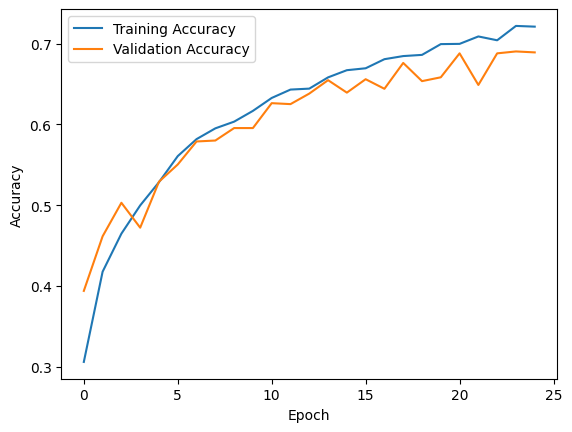

In [17]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

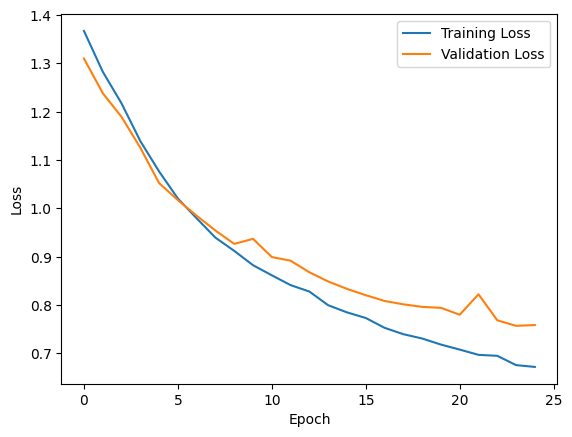

In [18]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Densenet121

In [21]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Multiply, Reshape, GlobalAveragePooling2D, Input

def densenet121_with_attention():
    # Load ResNet152 without the top layers (use include_top=False to exclude final Dense layers)
    base_model =  DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Get the output of the base model (feature maps of shape (8, 8, 2048))
    x = base_model.output
    
    # Attention mechanism on feature maps
    attention_weights = GlobalAveragePooling2D()(x)  # Apply global pooling to create attention weights
#     attention_weights = Dense(1024, activation='softmax')(attention_weights)
    attention_weights = Dense(1024, activation='relu')(attention_weights)  # Use same dimension as feature map depth
    attention_weights = Reshape((1, 1, 1024))(attention_weights)  # Reshape to match feature map shape
    
    # Apply attention (element-wise multiplication of feature maps and attention weights)
    attended_features = Multiply()([x, attention_weights])
    
    # Global Average Pooling after attention
    x = GlobalAveragePooling2D()(attended_features)
    
    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(4, activation='softmax')(x)  # Assuming 4 classes
    
    # Define the final model
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    return model


In [22]:
model_121 = densenet121_with_attention()
model_121.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model_121.fit(train_images, train_labels, epochs=25, batch_size=64, validation_data=(test_images, test_labels))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 65s 723ms/step - accuracy: 0.6894 - loss: 0.7503 - val_accuracy: 0.8600 - val_loss: 0.3795
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.8580 - loss: 0.3699 - val_accuracy: 0.8992 - val_loss: 0.2873
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.8896 - loss: 0.2903 - val_accuracy: 0.8814 - val_loss: 0.3327
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.8751 - loss: 0.3210 - val_accuracy: 0.8719 - val_loss: 0.3134
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9003 - loss: 0.2518 - val_accuracy: 0.9004 - val_loss: 0.2557
Epoch 6/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.9128 - loss: 0.2209 - val_accuracy: 0.9075 - val_loss: 0.2458
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9357 - loss: 0.1795 - val_accuracy: 0.9110 - val_loss: 0.2402
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step 

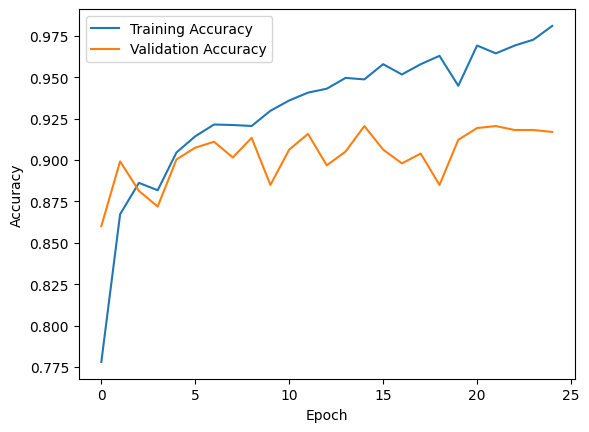

In [23]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

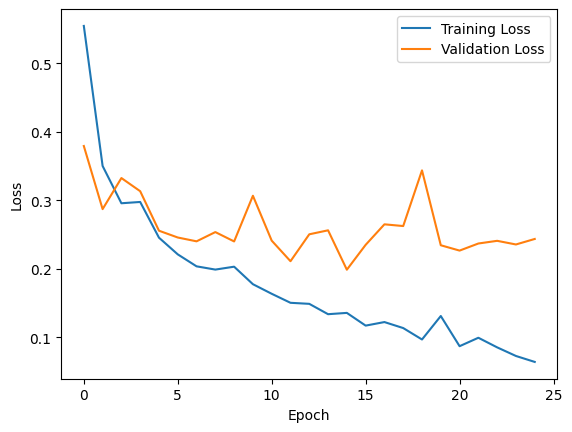

In [24]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Resnet101

In [15]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Multiply, Reshape, GlobalAveragePooling2D, Input

def resnet101_with_attention():
    # Load ResNet101 without the top layers (use include_top=False to exclude final Dense layers)
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Get the output of the base model (feature maps of shape (8, 8, 2048))
    x = base_model.output
    
    # Attention mechanism on feature maps
    attention_weights = GlobalAveragePooling2D()(x)  # Apply global pooling to create attention weights
    attention_weights = Dense(2048, activation='relu')(attention_weights)  # Use same dimension as feature map depth
    attention_weights = Reshape((1, 1, 2048))(attention_weights)  # Reshape to match feature map shape
    
    # Apply attention (element-wise multiplication of feature maps and attention weights)
    attended_features = Multiply()([x, attention_weights])
    
    # Global Average Pooling after attention
    x = GlobalAveragePooling2D()(attended_features)
    
    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(4, activation='softmax')(x)  # Assuming 4 classes
    
    # Define the final model
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    return model


In [25]:
model_101 = resnet101_with_attention()
model_101.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model_101.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(test_images, test_labels))

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 496ms/step - accuracy: 0.2767 - loss: 1.3944 - val_accuracy: 0.4626 - val_loss: 1.2787
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.4352 - loss: 1.2653 - val_accuracy: 0.4152 - val_loss: 1.2087
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.4580 - loss: 1.1900 - val_accuracy: 0.4614 - val_loss: 1.1387
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - accuracy: 0.5187 - loss: 1.0946 - val_accuracy: 0.5421 - val_loss: 1.0374
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.5504 - loss: 1.0405 - val_accuracy: 0.5587 - val_loss: 0.9895
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.5800 - loss: 0.9718 - val_accuracy: 0.5658 - val_loss: 0.9674
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.5990 - loss: 0.9209 - val_accuracy: 0.6180 - val_loss: 0.9071
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 22

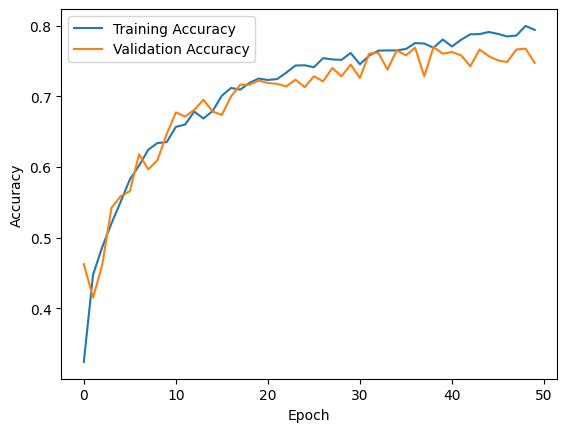

In [26]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

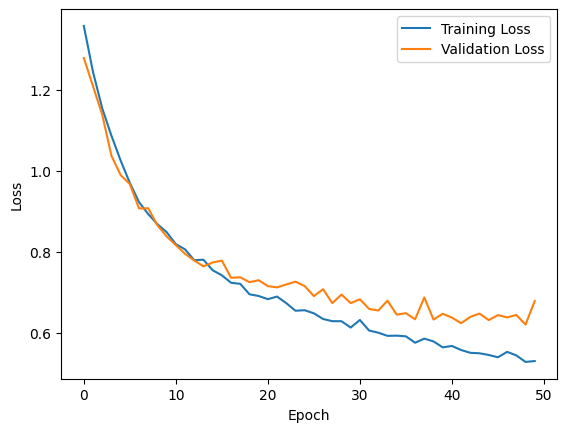

In [27]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 306ms/step
Precision: 0.7699
Recall: 0.7473
F1 Score: 0.7443
Accuracy: 0.7473
MCC: 0.6723
ROC AUC: 0.9210


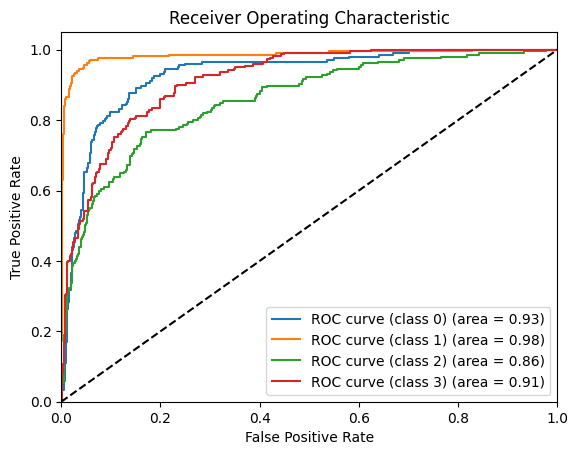

In [28]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

# Assuming you have your model already trained as model_50

# Step 1: Make predictions on the test set
# Get predicted probabilities
pred_probs = model_101.predict(test_images)

# Convert probabilities to class labels (using argmax for multi-class)
pred_labels = np.argmax(pred_probs, axis=1)

# Step 2: Convert true labels to class indices (if they're one-hot encoded)
true_labels = np.argmax(test_labels, axis=1)

# Step 3: Calculate metrics
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
accuracy = accuracy_score(true_labels, pred_labels)
mcc = matthews_corrcoef(true_labels, pred_labels)

# For ROC AUC, we need probabilities for the positive class
roc_auc = roc_auc_score(test_labels, pred_probs, multi_class='ovr')

# Step 4: Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Step 5: Plot ROC Curves for each class
n_classes = test_labels.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Densenet201

In [33]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet201 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Multiply, Reshape, GlobalAveragePooling2D, Input

def densenet201_with_attention():
    base_model =  DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Get the output of the base model (feature maps of shape (8, 8, 2048))
    x = base_model.output
    
    # Attention mechanism on feature maps
    attention_weights = GlobalAveragePooling2D()(x)  # Apply global pooling to create attention weights
#     attention_weights = Dense(1920, activation='softmax')(attention_weights)
    attention_weights = Dense(1920, activation='relu')(attention_weights)  # Use same dimension as feature map depth
    attention_weights = Reshape((1, 1, 1920))(attention_weights)  # Reshape to match feature map shape
    
    # Apply attention (element-wise multiplication of feature maps and attention weights)
    attended_features = Multiply()([x, attention_weights])
    
    # Global Average Pooling after attention
    x = GlobalAveragePooling2D()(attended_features)
    
    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(4, activation='softmax')(x)  # Assuming 4 classes
    
    # Define the final model
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    return model


In [34]:
model_201 = densenet201_with_attention()
model_201.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model_201.fit(train_images, train_labels, epochs=25, batch_size=64, validation_data=(test_images, test_labels))

Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6721 - loss: 0.7606 - val_accuracy: 0.8731 - val_loss: 0.3624
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.8693 - loss: 0.3672 - val_accuracy: 0.8019 - val_loss: 0.4985
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.8724 - loss: 0.3323 - val_accuracy: 0.8932 - val_loss: 0.2903
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.9190 - loss: 0.2146 - val_accuracy: 0.8814 - val_loss: 0.3544
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.9231 - loss: 0.2029 - val_accuracy: 0.9015 - val_loss: 0.2630
Epoch 6/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.9248 - loss: 0.1889 - val_accuracy: 0.9004 - val_loss: 0.2625
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.9309 - loss: 0.1721 - val_accuracy: 0.9004 - val_loss: 0.2599
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.9487 - loss: 0.1370 - val_accurac

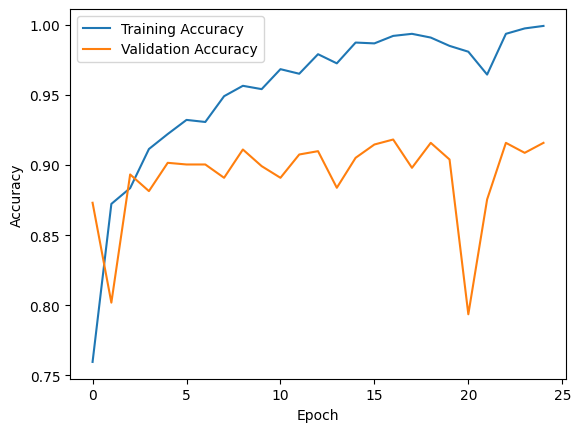

In [35]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

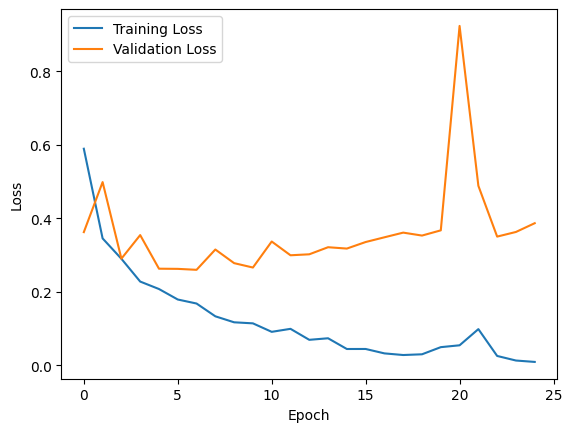

In [36]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 653ms/step
Precision: 0.9160
Recall: 0.9158
F1 Score: 0.9153
Accuracy: 0.9158
MCC: 0.8880
ROC AUC: 0.9863


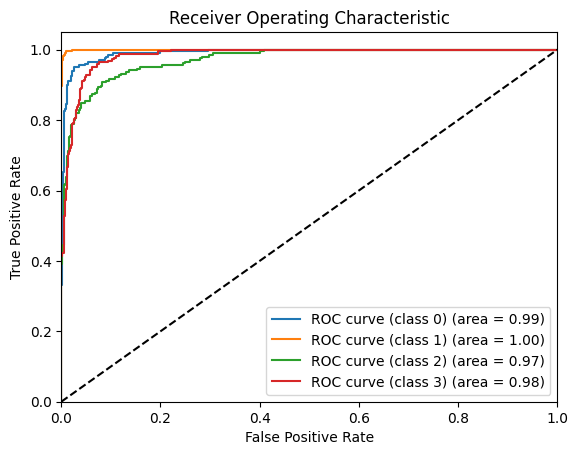

In [38]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

# Assuming you have your model already trained as model_50

# Step 1: Make predictions on the test set
# Get predicted probabilities
pred_probs = model_201.predict(test_images)

# Convert probabilities to class labels (using argmax for multi-class)
pred_labels = np.argmax(pred_probs, axis=1)

# Step 2: Convert true labels to class indices (if they're one-hot encoded)
true_labels = np.argmax(test_labels, axis=1)

# Step 3: Calculate metrics
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
accuracy = accuracy_score(true_labels, pred_labels)
mcc = matthews_corrcoef(true_labels, pred_labels)

# For ROC AUC, we need probabilities for the positive class
roc_auc = roc_auc_score(test_labels, pred_probs, multi_class='ovr')

# Step 4: Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Step 5: Plot ROC Curves for each class
n_classes = test_labels.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Resnet152

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Multiply, Reshape, GlobalAveragePooling2D, Input

def resnet152_with_attention():
    # Load ResNet152 without the top layers (use include_top=False to exclude final Dense layers)
    base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Get the output of the base model (feature maps of shape (8, 8, 2048))
    x = base_model.output
    
    # Attention mechanism on feature maps
    attention_weights = GlobalAveragePooling2D()(x)  # Apply global pooling to create attention weights
    attention_weights = Dense(2048, activation='relu')(attention_weights)  # Use same dimension as feature map depth
    attention_weights = Reshape((1, 1, 2048))(attention_weights)  # Reshape to match feature map shape
    
    # Apply attention (element-wise multiplication of feature maps and attention weights)
    attended_features = Multiply()([x, attention_weights])
    
    # Global Average Pooling after attention
    x = GlobalAveragePooling2D()(attended_features)
    
    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(4, activation='softmax')(x)  # Assuming 4 classes
    
    # Define the final model
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    return model


In [ ]:
model_152 = resnet152_with_attention()
model_152.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model_152.fit(train_images, train_labels, epochs=25, batch_size=64, validation_data=(test_images, test_labels))

In [ ]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

# Assuming you have your model already trained as model_50

# Step 1: Make predictions on the test set
# Get predicted probabilities
pred_probs = model_152.predict(test_images)

# Convert probabilities to class labels (using argmax for multi-class)
pred_labels = np.argmax(pred_probs, axis=1)

# Step 2: Convert true labels to class indices (if they're one-hot encoded)
true_labels = np.argmax(test_labels, axis=1)

# Step 3: Calculate metrics
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
accuracy = accuracy_score(true_labels, pred_labels)
mcc = matthews_corrcoef(true_labels, pred_labels)

# For ROC AUC, we need probabilities for the positive class
roc_auc = roc_auc_score(test_labels, pred_probs, multi_class='ovr')

# Step 4: Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Step 5: Plot ROC Curves for each class
n_classes = test_labels.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Mobilenetv1

In [66]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Multiply, Reshape, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam

def mobilenetv1_with_attention():
    # Load ResNet152 without the top layers (use include_top=False to exclude final Dense layers)
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Get the output of the base model (feature maps of shape (8, 8, 2048))
    x = base_model.output
    
    # Attention mechanism on feature maps
    attention_weights = GlobalAveragePooling2D()(x)  # Apply global pooling to create attention weights
    attention_weights = Dense(1024, activation='relu')(attention_weights)  # Use same dimension as feature map depth
    attention_weights = Reshape((1, 1, 1024))(attention_weights)  # Reshape to match feature map shape
    
    # Apply attention (element-wise multiplication of feature maps and attention weights)
    attended_features = Multiply()([x, attention_weights])
    
    # Global Average Pooling after attention
    x = GlobalAveragePooling2D()(attended_features)
    
    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(4, activation='softmax')(x)  # Assuming 4 classes
    
    # Define the final model
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    return model


In [69]:
# Get all global variables
variables = globals()
for i in variables:
    print(i)


__name__
__doc__
__package__
__loader__
__spec__
__builtin__
__builtins__
_ih
_oh
_dh
In
Out
get_ipython
exit
quit
open
_
__
___
_i
_ii
_iii
_i1
tf
data_dir
train_dataset
validation_dataset
_i2
np
dataset_to_numpy
train_images
train_labels
test_images
test_labels
_i3
to_categorical
num_classes
_i4
_i5
_5
_i6
layers
Model
Sequential
Conv2D
MaxPooling2D
Flatten
Dense
Multiply
Reshape
GlobalAveragePooling2D
Input
models
roc_curve
auc
plt
_i7
resnet50_with_attention
_i8
_i9
ResNet50
_i10
model
_i11
_i12
model_50
history
_i13
_i14
_i15
ResNet101
resnet101_with_attention
_i16
resnet152_with_attention
_i17
_i18
_i19
densenet121_with_attention
_i20
_i21
_i22
model_121
_i23
_i24
_i25
model_101
_i26
_i27
_i28
precision_score
recall_score
f1_score
accuracy_score
roc_auc_score
confusion_matrix
matthews_corrcoef
pred_probs
pred_labels
true_labels
precision
recall
f1
accuracy
mcc
roc_auc
n_classes
fpr
tpr
i
_i29
_i30
_i31
_i32
_i33
_i34
model_201
_i35
_i36
_i37
_i38
_i39
MobileNet
Adam
_i40
MobileNe

In [63]:
del DenseNet121

In [ ]:
train_images.shape

In [64]:
# Resize images to (224, 224)
train_images_resized = tf.image.resize(train_images, (224, 224))
test_images_resized = tf.image.resize(test_images, (224, 224))


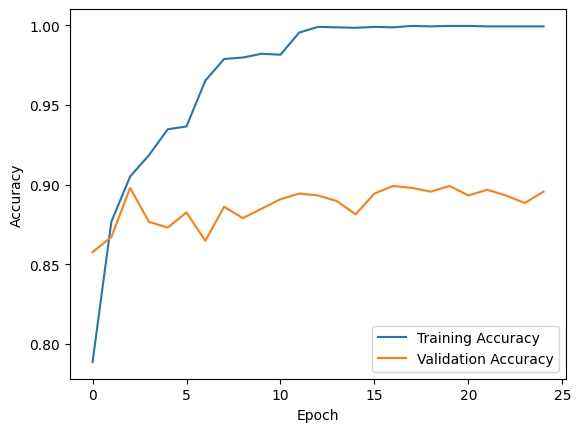

In [73]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [70]:
model_v1 = mobilenetv1_with_attention()
model_v1.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model_v1.fit(train_images_resized, train_labels, epochs=25, batch_size=64, validation_data=(test_images_resized, test_labels))

Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.7013 - loss: 0.7373 - val_accuracy: 0.8577 - val_loss: 0.3795
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8704 - loss: 0.3041 - val_accuracy: 0.8671 - val_loss: 0.3528
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9032 - loss: 0.2456 - val_accuracy: 0.8980 - val_loss: 0.3207
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9247 - loss: 0.1926 - val_accuracy: 0.8766 - val_loss: 0.3268
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9457 - loss: 0.1461 - val_accuracy: 0.8731 - val_loss: 0.3971
Epoch 6/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9312 - loss: 0.1647 - val_accuracy: 0.8826 - val_loss: 0.3433
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9625 - loss: 0.1026 - val_accuracy: 0.8648 - val_loss: 0.3698
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9793 - loss: 0.0735 - val_accuracy: 0.8861 -

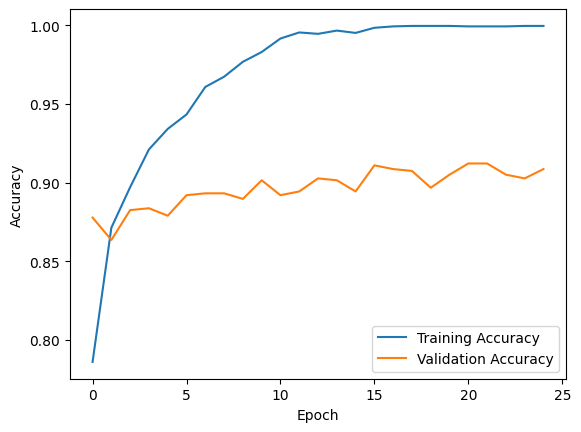

In [87]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

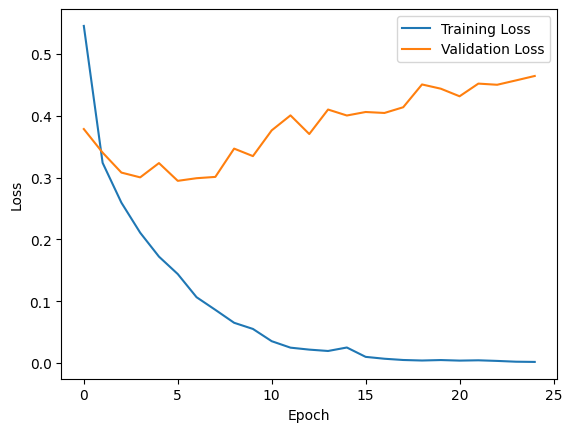

In [88]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: 0.9097
Recall: 0.9087
F1 Score: 0.9090
Accuracy: 0.9087
MCC: 0.8783
ROC AUC: 0.9853


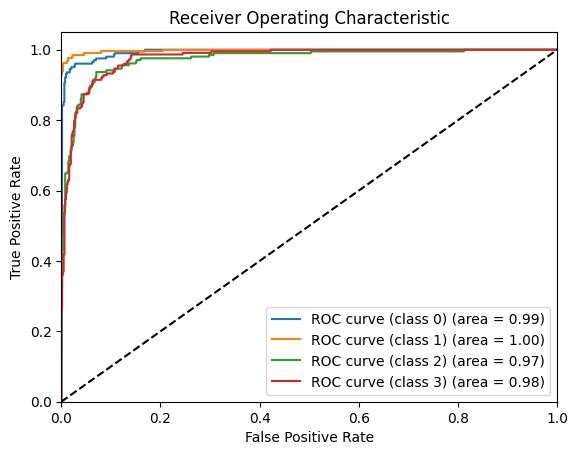

In [89]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

# Assuming you have your model already trained as model_50

# Step 1: Make predictions on the test set
# Get predicted probabilities
pred_probs = model_v1.predict(test_images_resized)

# Convert probabilities to class labels (using argmax for multi-class)
pred_labels = np.argmax(pred_probs, axis=1)

# Step 2: Convert true labels to class indices (if they're one-hot encoded)
true_labels = np.argmax(test_labels, axis=1)

# Step 3: Calculate metrics
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
accuracy = accuracy_score(true_labels, pred_labels)
mcc = matthews_corrcoef(true_labels, pred_labels)

# For ROC AUC, we need probabilities for the positive class
roc_auc = roc_auc_score(test_labels, pred_probs, multi_class='ovr')

# Step 4: Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Step 5: Plot ROC Curves for each class
n_classes = test_labels.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Mobilenetv2

In [76]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Multiply, Reshape, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

def mobilenet_v2_with_attention():
    # Load MobileNet V2 without the top layers and with ImageNet weights
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Freeze the base model layers
    base_model.trainable = False
    
    # Get the output of the base model (feature maps of shape (8, 8, 2048))
    x = base_model.output
    
    # Attention mechanism on feature maps
    attention_weights = GlobalAveragePooling2D()(x)  # Apply global pooling to create attention weights
    attention_weights = Dense(1280, activation='relu')(attention_weights)  # Use same dimension as feature map depth
    attention_weights = Reshape((1, 1, 1280))(attention_weights)  # Reshape to match feature map shape
    
    # Apply attention (element-wise multiplication of feature maps and attention weights)
    attended_features = Multiply()([x, attention_weights])
    
    # Global Average Pooling after attention
    x = GlobalAveragePooling2D()(attended_features)
    
    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(4, activation='softmax')(x)  # Assuming 4 classes
    
    # Define the final model
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    return model


In [90]:
model_v2 = mobilenet_v2_with_attention()
model_v2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model_v2.fit(train_images_resized, train_labels, epochs=25, batch_size=64, validation_data=(test_images_resized, test_labels))

Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.6904 - loss: 0.7445 - val_accuracy: 0.8636 - val_loss: 0.3928
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8802 - loss: 0.3218 - val_accuracy: 0.8565 - val_loss: 0.3769
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8987 - loss: 0.2656 - val_accuracy: 0.8600 - val_loss: 0.3761
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9342 - loss: 0.1766 - val_accuracy: 0.8695 - val_loss: 0.3351
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9483 - loss: 0.1592 - val_accuracy: 0.8885 - val_loss: 0.3202
Epoch 6/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9694 - loss: 0.1055 - val_accuracy: 0.8885 - val_loss: 0.3308
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9639 - loss: 0.0982 - val_accuracy: 0.8956 - val_loss: 0.3292
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9775 - loss: 0.0713 - val_accuracy: 0.8932 -

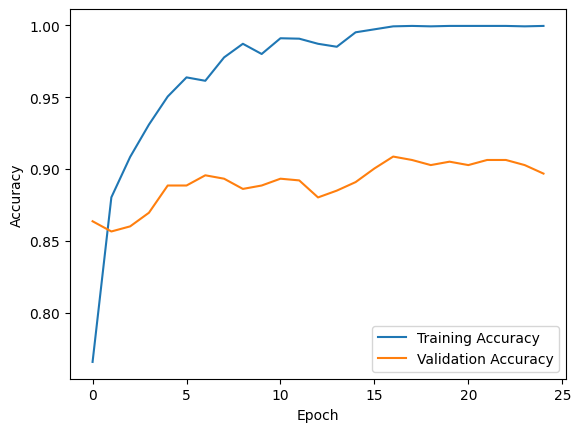

In [91]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

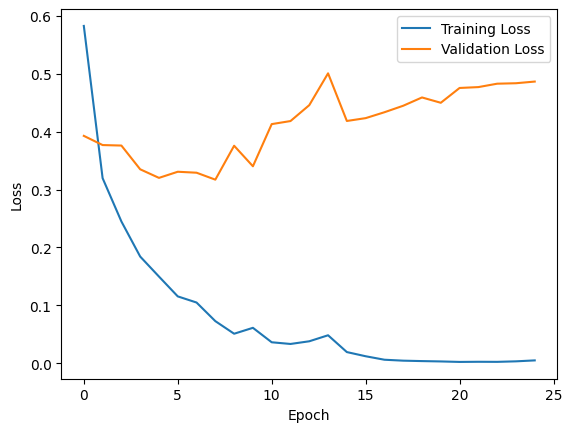

In [92]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step
Precision: 0.8984
Recall: 0.8968
F1 Score: 0.8973
Accuracy: 0.8968
MCC: 0.8625
ROC AUC: 0.9838


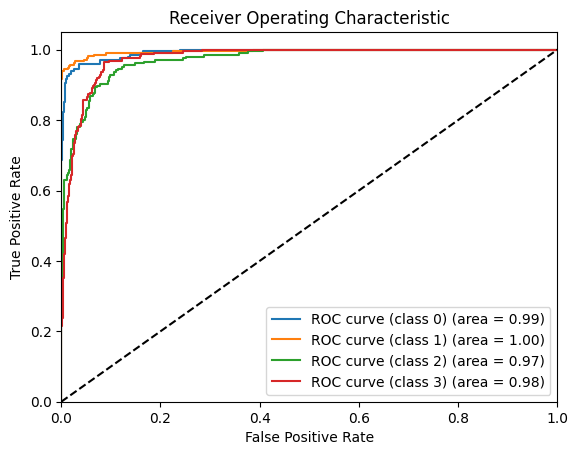

In [93]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

# Assuming you have your model already trained as model_50

# Step 1: Make predictions on the test set
# Get predicted probabilities
pred_probs = model_v2.predict(test_images_resized)

# Convert probabilities to class labels (using argmax for multi-class)
pred_labels = np.argmax(pred_probs, axis=1)

# Step 2: Convert true labels to class indices (if they're one-hot encoded)
true_labels = np.argmax(test_labels, axis=1)

# Step 3: Calculate metrics
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
accuracy = accuracy_score(true_labels, pred_labels)
mcc = matthews_corrcoef(true_labels, pred_labels)

# For ROC AUC, we need probabilities for the positive class
roc_auc = roc_auc_score(test_labels, pred_probs, multi_class='ovr')

# Step 4: Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Step 5: Plot ROC Curves for each class
n_classes = test_labels.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Mobilenetv3

In [95]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Multiply, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def mobilenet_v3_with_attention(input_shape=(224, 224, 3)):
    # Load MobileNetV3 without the top layers and with ImageNet weights
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Extract the feature maps
    x = base_model.output
    
    # Global average pooling to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)
    
    # Attention mechanism
    attention_weights = Dense(960, activation='relu')(x)  # Match the number of channels to the feature map (960)
    attention_weights = Dense(960, activation='softmax')(attention_weights)  # Softmax for attention distribution
    attention_weights = Reshape((1, 1, 960))(attention_weights)  # Reshape to match feature map shape
    
    # Apply attention (element-wise multiplication of feature maps and attention weights)
    feature_maps = base_model.output  # Feature maps of shape (7, 7, 960)
    attended_features = Multiply()([feature_maps, attention_weights])
    
    # Global Average Pooling after attention
    x = GlobalAveragePooling2D()(attended_features)
    
    # Final classification layers
    output = Dense(4, activation='softmax')(x)  # Assuming 4 classes
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [96]:
model_v3 = mobilenet_v3_with_attention((224, 224, 3))

model_v3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model_v3.fit(train_images_resized, train_labels, epochs=25, batch_size=64, validation_data=(test_images_resized, test_labels))

Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 86s 696ms/step - accuracy: 0.5177 - loss: 1.2011 - val_accuracy: 0.2396 - val_loss: 2.5990
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.8333 - loss: 0.7134 - val_accuracy: 0.2396 - val_loss: 3.7236
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.8962 - loss: 0.4842 - val_accuracy: 0.2396 - val_loss: 1.5298
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9118 - loss: 0.3887 - val_accuracy: 0.2396 - val_loss: 5.3812
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8745 - loss: 0.4457 - val_accuracy: 0.2396 - val_loss: 3.7995
Epoch 6/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8978 - loss: 0.3721 - val_accuracy: 0.2396 - val_loss: 11.7703
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.8725 - loss: 0.3893 - val_accuracy: 0.2396 - val_loss: 8.5668
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9101 - loss: 0.2876 - val_accuracy: 

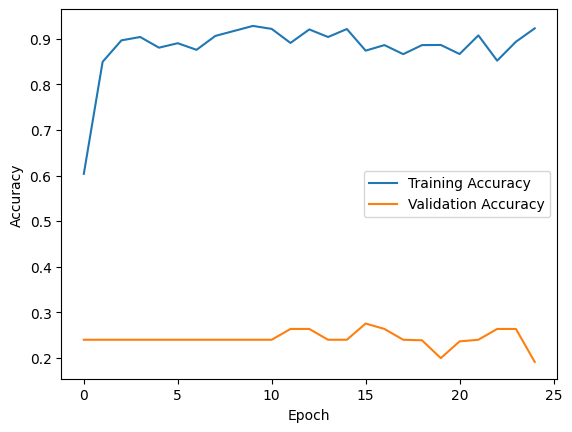

In [97]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

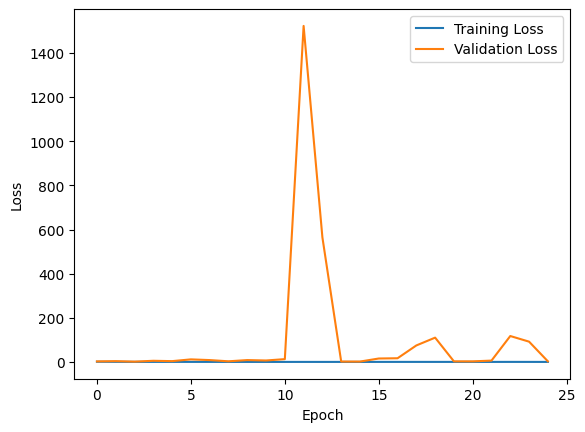

In [98]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: 0.9097
Recall: 0.9087
F1 Score: 0.9090
Accuracy: 0.9087
MCC: 0.8783
ROC AUC: 0.9853


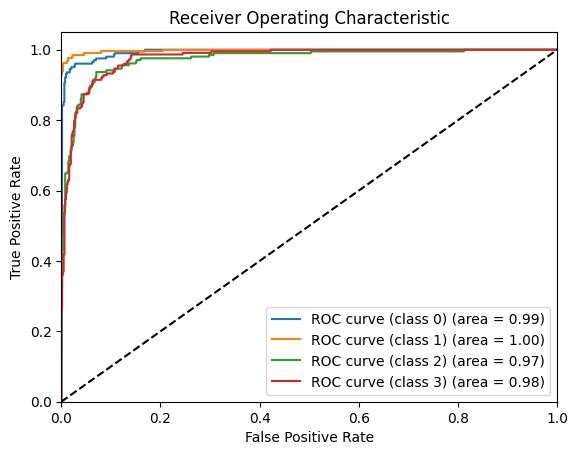

In [99]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

# Assuming you have your model already trained as model_50

# Step 1: Make predictions on the test set
# Get predicted probabilities
pred_probs = model_v1.predict(test_images_resized)

# Convert probabilities to class labels (using argmax for multi-class)
pred_labels = np.argmax(pred_probs, axis=1)

# Step 2: Convert true labels to class indices (if they're one-hot encoded)
true_labels = np.argmax(test_labels, axis=1)

# Step 3: Calculate metrics
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
accuracy = accuracy_score(true_labels, pred_labels)
mcc = matthews_corrcoef(true_labels, pred_labels)

# For ROC AUC, we need probabilities for the positive class
roc_auc = roc_auc_score(test_labels, pred_probs, multi_class='ovr')

# Step 4: Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Step 5: Plot ROC Curves for each class
n_classes = test_labels.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
